 <h1><center>Learning Bayesian Network Structure</center></h1>


The following code contains class/function definitions

In [22]:
from sys import maxsize
import numpy as np
import math
import random
import copy
import itertools
import networkx as nx
import matplotlib.pyplot as plt

#=====================================================================================================

class Node:
    def __init__(self, name, configurations=['1','0'], thetas={'':[0.5,0.5]}):
        self.name=name
        self.configurations=configurations
        self.thetas=thetas

    def generate_sample(self,parents_config=''):
        r=random.uniform(0,1)
        threshold=0
        count=0
        for theta in self.thetas[parents_config]:
            threshold+=theta
            if r<threshold:
                return self.configurations[count]
            count+=1            

#________________________________________________________________________________________________________

class DAG:
    def __init__(self,nodes,randomInit=False):
        self.size=len(nodes)
        self.nodes=nodes
        self.adj_mat=np.zeros((self.size,self.size),dtype=int)
        if randomInit:
            for i in range(self.size):
                for j in range(self.size):
                    if random.randint(0,1):
                        self.add_edge((i,j))   
    def get_parents(self,node):
        return np.where(self.adj_mat[:,node]==1)[0]
    def get_successors(self,node):
        return np.where(self.adj_mat[node,:]==1)[0]
    def add_edge(self,edge):
        u=edge[0]
        v=edge[1]
        if self.adj_mat[u,v]==1 or self.adj_mat[v,u]==1 or u==v or self.path_exists((v,u)):
            return False
        self.adj_mat[u,v]=1
        return True
    def remove_edge(self,edge):
        u=edge[0]
        v=edge[1]
        if self.adj_mat[u,v]==0 or u==v:
            return False
        self.adj_mat[u,v]=0
        return True
    def invert_edge(self,edge):
        u=edge[0]
        v=edge[1]
        if self.adj_mat[u,v]==0 or u==v:
            return False
        self.adj_mat[u,v]=0
        if self.path_exists((u,v)):
            self.adj_mat[u,v]=1
            return False
        self.adj_mat[v,u]=1        
        return True
    def path_exists(self,edge):
        u=edge[0]
        v=edge[1]
        explored=set()
        frontier=[]
        frontier.append(u)
        while frontier:
            node=frontier.pop()
            if node==v:
                return True
            if node not in explored and node not in frontier:
                explored.add(node)
                for neighbor in self.get_successors(node):
                    frontier.append(neighbor)
        return False
    def topological_sort(self):
        explored=set()
        result = []
        def recursive_helper(node,result):
            for neighbor in self.get_successors(node):
                if neighbor not in explored:
                    explored.add(neighbor)
                    recursive_helper(neighbor,result)
            result.insert(0,node)
        for node in range(self.size):
            if(node not in explored):
                recursive_helper(node,result)
        return result
    def generate_sample(self):
        order = self.topological_sort()
        sample = np.zeros(self.size,dtype=str)
        for node in order:
            #get parent's configuration
            parents_config = ''
            for parent in self.get_parents(node):
                parents_config += str(sample[parent])
            #generate sample
            sample[node] = self.nodes[node].generate_sample(parents_config)
        return sample
    def print(self):
        print(self.adj_mat)
    def draw(self,message='graph plot'):
        G = nx.from_numpy_array(self.adj_mat,create_using=nx.DiGraph)
        G = nx.relabel_nodes(G,{i:name for (i,name) in zip(range(self.size),[node.name for node in self.nodes])})
        posG = nx.circular_layout(G)
        plt.figure(message)
        nx.draw_networkx(G, pos=posG, node_color='#B0DBFF')
        plt.draw()
        plt.show()

#=====================================================================================================

def node_score(graph, node, count):
    score = 0

    num_configs_parents = np.sum([len(graph.nodes[parent].configurations) for parent in  graph.get_parents(node)])
    if num_configs_parents == 0:
        num_configs_parents = 1
    denominator = num_configs_parents * len(graph.nodes[node].configurations)

    if len(graph.get_parents(node)) != 0:
        for parents_config in itertools.product(
                *[graph.nodes[parent].configurations for parent in graph.get_parents(node)]):
            n_ij = 0
            alpha_ij = 0
            for node_config in graph.nodes[node].configurations:
                ijk = str(node) + ',' + ''.join(parents_config) + ',' + node_config
                if ijk in count:
                    n_ijk = count[ijk]
                else:
                    n_ijk = 0

                # equivalent sample size = 1
                alpha_ijk = 1/denominator

                score += math.lgamma(alpha_ijk + n_ijk) - math.lgamma(alpha_ijk)
                n_ij += n_ijk
                alpha_ij += alpha_ijk
            score += math.lgamma(alpha_ij) - math.lgamma(alpha_ij + n_ij)
    else:
        n_ij = 0
        alpha_ij = 0
        for node_config in graph.nodes[node].configurations:
            if str(node) + ',,' + node_config in count:
                n_ijk = count[str(node) + ',,' + node_config]
            else:
                n_ijk = 0

            # equivalent sample size = 1
            alpha_ijk = 1/denominator

            score += math.lgamma(alpha_ijk + n_ijk) - math.lgamma(alpha_ijk)
            n_ij += n_ijk
            alpha_ij += alpha_ijk
        score += math.lgamma(alpha_ij) - math.lgamma(alpha_ij + n_ij)
    return score

#________________________________________________________________________________________________________

def accuracy(referenceDag, testingDag):
    #True Positives + True Negatives: 'presence of edges with same orientation' + 'absence of edges'
    adj_R = referenceDag.adj_mat
    adj_T = testingDag.adj_mat
    size = referenceDag.size
    
    correct = 0   #TP + TN
    wrong = 0     #FP + FN 
    for i in range(size):
        for j in range(i,size):
            if adj_R[i][j] == adj_T[i][j]:
                correct += 1
            else:
                wrong += 1
    
    return correct/(correct+wrong)

#________________________________________________________________________________________________________

def beam_search(b, nodes, dataset, suppressOutput=False):
    graphs = [DAG(nodes, True) for i in range(b)]
    counts = [{} for i in range(b)]
    scores = [0 for i in range(b)]

    # calculate counts and score for initial graphs
    for graph, count, index in zip(graphs, counts, range(b)):

        for example in dataset:
            for node in range(graph.size):
                ijk = str(node) + ','  # i
                for parent in graph.get_parents(node):
                    ijk += str(example[parent])  # j
                ijk += ',' + str(example[node])  # k
                if ijk in count:
                    count[ijk] += 1
                else:
                    count[ijk] = 1
        for node in range(graph.size):
            scores[index] += node_score(graph, node, count)
    
    iter = 0
    best_score = -maxsize
    while True:
        new_graphs = copy.deepcopy(graphs)
        new_counts = copy.deepcopy(counts)
        new_scores = copy.deepcopy(scores)

        #TESTING
        #counter=0

        for graph, count, score in zip(graphs, counts, scores):
            #TESTING
            #print('\n\nDISCOVERING FROM GRAPH #'+str(counter))
            #counter+=1
            #graph.draw()
            #print(graph.adj_mat)
            #print('^score:' + str(score))

            for i in range(graph.size):
                for j in range(graph.size):

                    # try adding an edge
                    if graph.add_edge((i, j)):
                        #TESTING
                        #print('\nadding edge: (' + str(i) + ','+str(j)+')')
                        new_graphs.append(copy.deepcopy(graph))
                        new_graph = new_graphs[-1]
                        new_counts.append(copy.deepcopy(count))
                        new_count = new_counts[-1]

                        graph.remove_edge((i, j))

                        # update new_count
                        for j_config in graph.nodes[j].configurations:
                            key = str(j) + ','
                            for parents_config in itertools.product(
                                    *[graph.nodes[parent].configurations for parent in graph.get_parents(j)]):
                                key = str(node) + ',' + ''.join(parents_config) + ',' + str(j_config)
                                if key in new_count:
                                    del new_count[key]

                        for example in dataset:
                            ijk = str(j) + ','  # i
                            for parent in new_graph.get_parents(j):
                                ijk += str(example[parent])  # j
                            ijk += ',' + str(example[j])  # k
                            if ijk in new_count:
                                new_count[ijk] += 1
                            else:
                                new_count[ijk] = 1

                        # update new_score
                        old_node_score = node_score(graph, j, count)
                        new_node_score = node_score(new_graph, j, new_count)
                        new_scores.append(score - old_node_score + new_node_score)

                        #TESTING
                        #new_graph.draw()
                        #print(new_graph.adj_mat)
                        #print('^score:' + str(score - old_node_score + new_node_score))

                    # try removing an edge
                    if graph.remove_edge((i, j)):
                        #TESTING
                        #print('\nremoving edge: (' + str(i) + ','+str(j)+')')
                        new_graphs.append(copy.deepcopy(graph))
                        new_counts.append(copy.deepcopy(count))
                        new_graph = new_graphs[-1]
                        new_count = new_counts[-1]

                        graph.add_edge((i, j))

                        # update new_count
                        for j_config in graph.nodes[j].configurations:
                            key = str(j) + ','
                            for parents_config in itertools.product(
                                    *[graph.nodes[parent].configurations for parent in graph.get_parents(j)]):
                                key = str(node) + ',' + ''.join(parents_config) + ',' + str(j_config)
                                if key in new_count:
                                    del new_count[key]

                        for example in dataset:
                            ijk = str(j) + ','  # i
                            for parent in new_graph.get_parents(j):
                                ijk += str(example[parent])  # j
                            ijk += ',' + str(example[j])  # k
                            if ijk in new_count:
                                new_count[ijk] += 1
                            else:
                                new_count[ijk] = 1

                        # update new_score
                        old_node_score = node_score(graph, j, count)
                        new_node_score = node_score(new_graph, j, new_count)
                        new_scores.append(score - old_node_score + new_node_score)

                        #TESTING
                        #new_graph.draw()
                        #print(new_graph.adj_mat)
                        #print('^score:' + str(score - old_node_score + new_node_score))
                    
                    # try inverting an edge 
                    if graph.invert_edge((i, j)):
                        #TESTING
                        #print('\ninverting edge: (' + str(i) + ','+str(j)+')')
                        new_graphs.append(copy.deepcopy(graph))
                        new_counts.append(copy.deepcopy(count))
                        new_graph = new_graphs[-1]
                        new_count = new_counts[-1]

                        graph.invert_edge((j, i))

                        # update new_count
                        for node in [i, j]:
                            for node_config in graph.nodes[node].configurations:
                                key = str(node) + ','
                                for parents_config in itertools.product(
                                        *[graph.nodes[parent].configurations for parent in graph.get_parents(node)]):
                                    key = str(node) + ',' + ''.join(parents_config) + ',' + str(node_config)
                                    if key in new_count:
                                        del new_count[key]

                            for example in dataset:
                                ijk = str(node) + ','  # i
                                for parent in new_graph.get_parents(node):
                                    ijk += str(example[parent])  # j
                                ijk += ',' + str(example[node])  # k
                                if ijk in new_count:
                                    new_count[ijk] += 1
                                else:
                                    new_count[ijk] = 1

                        # update new_score
                        old_node_i_score = node_score(graph, i, count)
                        old_node_j_score = node_score(graph, j, count)
                        new_node_i_score = node_score(new_graph, i, new_count)
                        new_node_j_score = node_score(new_graph, j, new_count)
                        new_scores.append(score - old_node_i_score - old_node_j_score + new_node_i_score + new_node_j_score)

                        #TESTING
                        #new_graph.draw()
                        #print(new_graph.adj_mat)
                        #print('^score:' + str(score - old_node_i_score - old_node_j_score + new_node_i_score + new_node_j_score))

        # save b best scoring graphs
        order = np.argpartition(np.array(new_scores), -b)[-b:]
        graphs = [new_graphs[i] for i in order]
        counts = [new_counts[i] for i in order]
        scores = [new_scores[i] for i in order]

        # is there any progress?
        #print('\nchecking for progress...')
        if max(scores) > best_score:
            best_score = max(scores)
            if suppressOutput == False:
                print("\nGeneration " + str(iter) + ':\nbest score: ' + str(best_score))
                print('new generation has ' + str(len(new_graphs)) + ' DAGs, of which ' + str(b) + ' will survive.')
                graphs[0].draw()
            iter += 1
        else:
            if suppressOutput == False:
                print('\nno progress... ending...')
            break

    return graphs[0]

# Execution
By running the corresponding block, select the Bayesian Network you wish to learn the structure of:

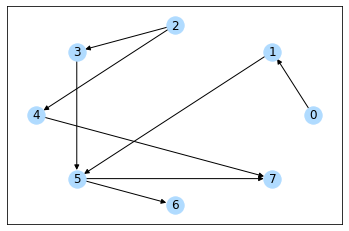

In [16]:
my_dag1 = DAG([
    Node("0",['1','0'],{'':[0.01, 0.99]}),                                                      #asia
    Node("1",['1','0'],{'1':[0.05, 0.95], '0':[ 0.01, 0.99]}),                                  #tub
    Node("2",['1','0'],{'':[0.5, 0.5]}),                                                        #smoke
    Node("3",['1','0'],{'1':[ 0.1, 0.9], '0':[0.01, 0.99]}),                                    #lung
    Node("4",['1','0'],{'1':[0.6, 0.4], '0':[0.3, 0.7]}),                                       #bronc
    Node("5",['1','0'],{'11':[1.0, 0.0], '01':[1.0, 0.0], '10':[1.0, 0.0], '00':[0.0, 1.0]}),   #either
    Node("6",['1','0'],{'1':[0.98, 0.02], '0':[0.05, 0.95]}),                                   #xray
    Node("7",['1','0'],{'11': [0.9, 0.1], '01':[ 0.7, 0.3], '10':[0.8, 0.2],'00':[0.1, 0.9]})]) #dysp

my_dag1.add_edge((0,1))
my_dag1.add_edge((1,5))
my_dag1.add_edge((2,3))
my_dag1.add_edge((2,4))
my_dag1.add_edge((3,5))
my_dag1.add_edge((4,7))
my_dag1.add_edge((5,6))
my_dag1.add_edge((5,7))

my_dag=my_dag1
my_dag.draw()

In [ ]:
my_dag2 = DAG([
    Node("0",['l','h'],{'':[0.9, 0.1]}),                                                                #Pollution
    Node("1",['1','0'],{'':[0.3, 0.7]}),                                                                #Smoker
    Node("2",['1','0'],{'l1':[0.03, 0.97],'h1':[0.05, 0.95],'l0':[0.001, 0.999],'h0':[0.02, 0.98]}),    #Cancer
    Node("3",['+','-'],{'1':[0.9, 0.1], '0':[0.2, 0.8]}),                                               #Xray
    Node("4",['1','0'],{'1':[0.65, 0.35], '0':[0.3, 0.7]})])                                            #Dyspnoea

my_dag2.add_edge((0,2))
my_dag2.add_edge((1,2))
my_dag2.add_edge((2,3))
my_dag2.add_edge((2,4))

my_dag=my_dag2
my_dag.draw()

In [ ]:
my_dag3 = DAG([
    Node("0",['1','0'],{'':[0.9, 0.1]}),                   #A  
    Node("1",['1','0'],{'1':[0.3, 0.7],'0':[0.1,0.9]}),    #B 
    Node("2",['1','0'],{'1':[0.2,0.8],'0':[0.4,0.6]})])    #C

my_dag3.add_edge((0,1))
my_dag3.add_edge((1,2))

my_dag=my_dag3
my_dag.draw()

Choose the number of examples you would like in the dataset (n), and the size of the beam (b) for the Beam Search algorithm:

In [32]:
n=2500 #number of examples
b=10   #size of beam

print("Generating dataset with " + str(n) +" entries...\n")
dataset=np.zeros((n,my_dag.size),dtype=str)
for i in range(n):
    dataset[i,:] = my_dag.generate_sample()
    
print(dataset)
print('')

Generating dataset with 2500 entries...

[['0' '0' '1' ... '0' '0' '1']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '1' ... '0' '0' '0']
 ...
 ['0' '0' '1' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '1']
 ['0' '0' '0' ... '0' '0' '1']]



### Output

Accuracy measures the fraction of identical (also in direction) edges (TP) plus the fraction of edges missing in both (TN) over all the possible edges (TP+TN+FP+FN)

Chose to learn structure of:


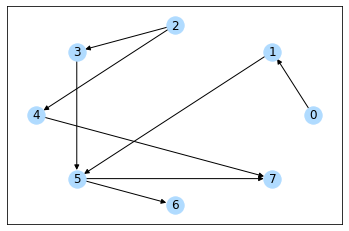

Running beam_search with beam size b=20...


Generation 0:
best score: -4500.481281076497
new generation has 778 DAGs, of which 20 will survive.

Generation 1:
best score: -4492.991253193165
new generation has 816 DAGs, of which 20 will survive.

Generation 2:
best score: -4486.211010810647
new generation has 794 DAGs, of which 20 will survive.

Generation 3:
best score: -4481.57891622176
new generation has 822 DAGs, of which 20 will survive.

Generation 4:
best score: -4474.286534417281
new generation has 865 DAGs, of which 20 will survive.

Generation 5:
best score: -4470.305206610468
new generation has 880 DAGs, of which 20 will survive.

Generation 6:
best score: -4468.24039948026
new generation has 859 DAGs, of which 20 will survive.

Generation 7:
best score: -4466.763598339122
new generation has 956 DAGs, of which 20 will survive.

Generation 8:
best score: -4465.924676724781
new generation has 974 DAGs, of which 20 will survive.

Generation 9:
best score: -4465.92467672478
new 

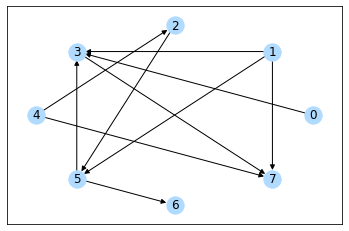


accuracy: 0.7222222222222222%


In [31]:
print("Chose to learn structure of:")
my_dag.draw()

print("Running beam_search with beam size b="+str(b)+'...\n')
result=beam_search(b, my_dag.nodes,dataset)

print('Final Belief Network:')
result.draw()    

print('\naccuracy: ' + str(accuracy(my_dag,result)) + '%')

# Testing

If you wish to observe how the accuracy scales for larger and larger datasets, use the following code to specify the number of tests (num_tests) to perform (each one num_redundancy_tests times, in order to smooth out the result) up to a maximum dataset size.

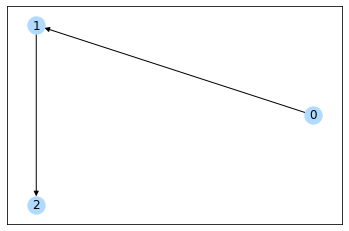

 testing progress: 100.0%                   

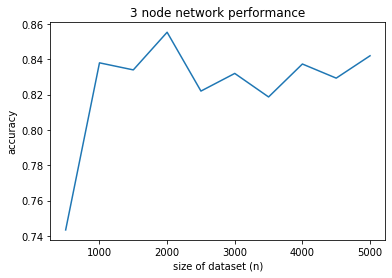

In [33]:
my_dag3 = DAG([
    Node("0",['1','0'],{'':[0.9, 0.1]}),                   #A  
    Node("1",['1','0'],{'1':[0.3, 0.7],'0':[0.1,0.9]}),    #B 
    Node("2",['1','0'],{'1':[0.2,0.8],'0':[0.4,0.6]})])    #C

my_dag3.add_edge((0,1))
my_dag3.add_edge((1,2))

my_dag=my_dag3
my_dag.draw()

num_tests = 10 
num_redundancy_tests = 250
max_dataset_n = 5000

dataset_sizes_n = [int(n * max_dataset_n/num_tests) for n in range(1,num_tests+1)]
accuracies = np.zeros(num_tests)
for count in range(num_tests):
    n = int(count * max_dataset_n/num_tests) 
    redundant_accuracies = np.zeros(num_redundancy_tests)
    for i in range(num_redundancy_tests):
        dataset=np.zeros((n, my_dag.size),dtype=str)
        for j in range(n):
            dataset[j,:] = my_dag.generate_sample()
        redundant_accuracies[i] = accuracy(my_dag, beam_search(b, my_dag.nodes,dataset,True))
        print('\r', 'testing progress: ' + str(100*(count*num_redundancy_tests + i + 1)/(num_tests*num_redundancy_tests)) + '%                   ', end='')
    accuracies[count] = np.mean(redundant_accuracies)
    
plt.plot(dataset_sizes_n, accuracies)
plt.title('3 node network performance')
plt.xlabel('size of dataset (n)')
plt.ylabel('accuracy')
plt.savefig('C:\\Users\\loren\\Desktop\\3node_result.png')

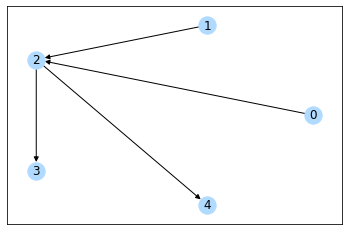

 testing progress: 100.0%                   

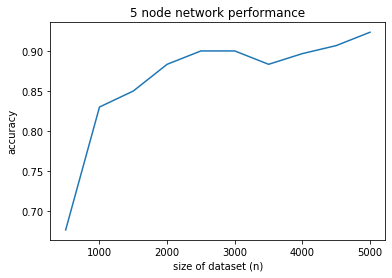

In [11]:
my_dag2 = DAG([
    Node("0",['l','h'],{'':[0.9, 0.1]}),                                                                #Pollution
    Node("1",['1','0'],{'':[0.3, 0.7]}),                                                                #Smoker
    Node("2",['1','0'],{'l1':[0.03, 0.97],'h1':[0.05, 0.95],'l0':[0.001, 0.999],'h0':[0.02, 0.98]}),    #Cancer
    Node("3",['+','-'],{'1':[0.9, 0.1], '0':[0.2, 0.8]}),                                               #Xray
    Node("4",['1','0'],{'1':[0.65, 0.35], '0':[0.3, 0.7]})])                                            #Dyspnoea

my_dag2.add_edge((0,2))
my_dag2.add_edge((1,2))
my_dag2.add_edge((2,3))
my_dag2.add_edge((2,4))

my_dag=my_dag2
my_dag.draw()

num_tests = 10 
num_redundancy_tests = 20
max_dataset_n = 5000

dataset_sizes_n = [int(n * max_dataset_n/num_tests) for n in range(1,num_tests+1)]
accuracies1 = np.zeros(num_tests)
for count in range(num_tests):
    n = int(count * max_dataset_n/num_tests) 
    redundant_accuracies = np.zeros(num_redundancy_tests)
    for i in range(num_redundancy_tests):
        dataset=np.zeros((n, my_dag.size),dtype=str)
        for j in range(n):
            dataset[j,:] = my_dag.generate_sample()
        redundant_accuracies[i] = accuracy(my_dag, beam_search(b, my_dag.nodes,dataset,True))
        print('\r', 'testing progress: ' + str(100*(count*num_redundancy_tests + i + 1)/(num_tests*num_redundancy_tests)) + '%                   ', end='')
    accuracies1[count] = np.mean(redundant_accuracies)
    
plt.plot(dataset_sizes_n, accuracies1)
plt.title('5 node network performance')
plt.xlabel('size of dataset (n)')
plt.ylabel('accuracy')
plt.savefig('C:\\Users\\loren\\Desktop\\5node_result.png')

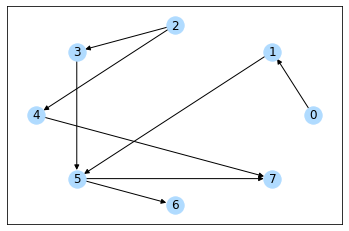

 testing progress: 100.0%                   

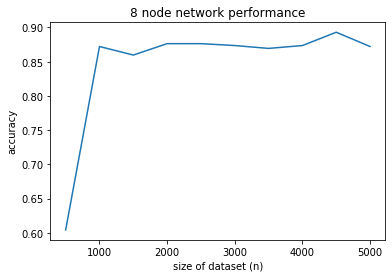

In [10]:
my_dag1 = DAG([
    Node("0",['1','0'],{'':[0.01, 0.99]}),                                                      #asia
    Node("1",['1','0'],{'1':[0.05, 0.95], '0':[ 0.01, 0.99]}),                                  #tub
    Node("2",['1','0'],{'':[0.5, 0.5]}),                                                        #smoke
    Node("3",['1','0'],{'1':[ 0.1, 0.9], '0':[0.01, 0.99]}),                                    #lung
    Node("4",['1','0'],{'1':[0.6, 0.4], '0':[0.3, 0.7]}),                                       #bronc
    Node("5",['1','0'],{'11':[1.0, 0.0], '01':[1.0, 0.0], '10':[1.0, 0.0], '00':[0.0, 1.0]}),   #either
    Node("6",['1','0'],{'1':[0.98, 0.02], '0':[0.05, 0.95]}),                                   #xray
    Node("7",['1','0'],{'11': [0.9, 0.1], '01':[ 0.7, 0.3], '10':[0.8, 0.2],'00':[0.1, 0.9]})]) #dysp

my_dag1.add_edge((0,1))
my_dag1.add_edge((1,5))
my_dag1.add_edge((2,3))
my_dag1.add_edge((2,4))
my_dag1.add_edge((3,5))
my_dag1.add_edge((4,7))
my_dag1.add_edge((5,6))
my_dag1.add_edge((5,7))

my_dag=my_dag1
my_dag.draw()

num_tests = 10 
num_redundancy_tests = 20
max_dataset_n = 5000

dataset_sizes_n = [int(n * max_dataset_n/num_tests) for n in range(1,num_tests+1)]
accuracies2 = np.zeros(num_tests)
for count in range(num_tests):
    n = int(count * max_dataset_n/num_tests) 
    redundant_accuracies = np.zeros(num_redundancy_tests)
    for i in range(num_redundancy_tests):
        dataset=np.zeros((n, my_dag.size),dtype=str)
        for j in range(n):
            dataset[j,:] = my_dag.generate_sample()
        redundant_accuracies[i] = accuracy(my_dag, beam_search(b, my_dag.nodes,dataset,True))
        print('\r', 'testing progress: ' + str(100*(count*num_redundancy_tests + i + 1)/(num_tests*num_redundancy_tests)) + '%                   ', end='')
    accuracies2[count] = np.mean(redundant_accuracies)
    
plt.plot(dataset_sizes_n, accuracies2)
plt.title('8 node network performance')
plt.xlabel('size of dataset (n)')
plt.ylabel('accuracy')
plt.savefig('C:\\Users\\loren\\Desktop\\8node_result.png')